In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy as sp
import faraway.utils

In [1]:
import faraway.datasets.aatemp
aatemp = faraway.datasets.aatemp.load()
aatemp.head()

,year,temp
0,1854,49.15
1,1855,46.52
2,1871,48.80
3,1881,47.95
4,1882,47.31


In [2]:
print(faraway.datasets.aatemp.DESCR)


Annual mean temperatures in Ann Arbor, Michigan

Description:

     The data comes from the U.S. Historical Climatology Network.

Variables:

     A data frame with 115 observations on the following 2 variables.

     year year from 1854 to 2000

     temp annual mean temperatures in degrees F in Ann Arbor

Source:

     United States Historical Climatology Network: <URL:
     http://www.ncdc.noaa.gov/oa/climate/research/ushcn/ushcn.html>



<AxesSubplot:xlabel='year', ylabel='temp'>

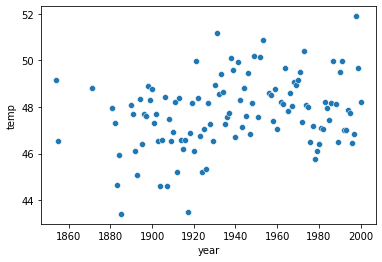

In [5]:
sns.scatterplot(y="temp", x="year", data=aatemp)

There is a linear trend.

Temporal data is prone to correlated errors. How do I check for it? </br>
Fir a model and examine Durbin-Watson. </br>

In [40]:
lmod = smf.ols("temp ~ year", data=aatemp).fit()
lmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   temp   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     10.55
Date:                Sat, 20 Aug 2022   Prob (F-statistic):            0.00153
Time:                        15:24:20   Log-Likelihood:                -206.18
No. Observations:                 115   AIC:                             416.4
Df Residuals:                     113   BIC:                             421.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.0055      7.311      3.284      0.001       9.522      38.489
year           0.0122      0.004      3.247      0.002       0.005       0.020
==============================================================================
Omnibus:                        0.103   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.950   Jarque-Bera (JB):                0.134
Skew:                          -0.068   Prob(JB):                        0.935
Kurtosis:                       2.902   Cond. No.                     1.04e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
%run utils.ipynb

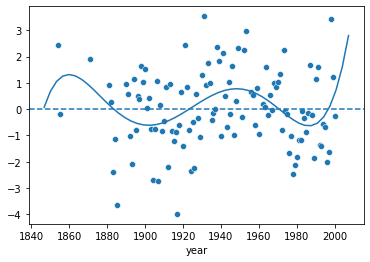

In [11]:
f, ax = plt.subplots(1, 1)

sns.scatterplot(y=lmod.resid, x=aatemp["year"])
plt.axhline(0, ls='--')

p = np.poly1d(np.polyfit(aatemp["year"], lmod.resid, 5))
xlim = ax.get_xlim()
xr = np.linspace(xlim[0], xlim[1], num=50)
ax.plot(xr, p(xr))

<AxesSubplot:>

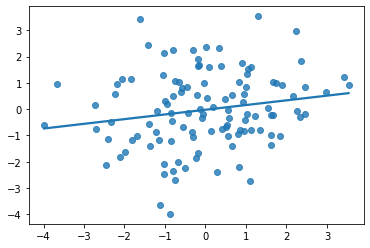

In [42]:
sns.regplot(y=lmod.resid[1:], x=lmod.resid[:-1], ci=None)

In [47]:
residmod = sm.OLS(np.array(lmod.resid[1:]), np.array(lmod.resid[:-1])).fit()
residmod.sumary()

   coefs stderr tvalues pvalues
x1 0.179  0.091    1.95  0.0531

n=114 p=2 Residual SD=1.424 R-squared=0.03


There is a minor positive relation, close to significant. These all indicate a small between-error correalation. </br>
A possible solution would be to include the correlation explicitly in the model : GLSAR model

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


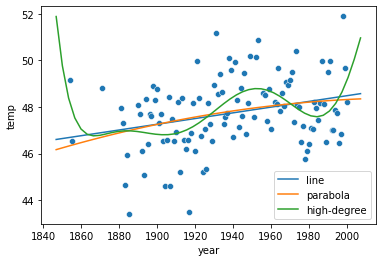

In [127]:
f, ax = plt.subplots(1, 1)

sns.scatterplot(y="temp", x="year", data=aatemp, ax=ax)

xlim = ax.get_xlim()
xr = np.linspace(xlim[0], xlim[1], num=50)

l = np.poly1d(np.polyfit(aatemp["year"], aatemp["temp"], 1))
p = np.poly1d(np.polyfit(aatemp["year"], aatemp["temp"], 2))
h = np.poly1d(np.polyfit(aatemp["year"], aatemp["temp"], 10))
ax.plot(xr, l(xr), label="line")
ax.plot(xr, p(xr), label="parabola")
ax.plot(xr, h(xr), label="high-degree")
plt.legend()


In [133]:
lmod.get_prediction(
    pd.DataFrame({"year": [2020]})
).predicted_mean, h(2020)

(array([48.72478209]), 54.337642669677734)

As we see, the difference in the predictions is dramatic, as expected. </br>
High-degree model is clearly an overfit.

### next
Suppose someone claims that the temperature was constant until 1930 and then
began a linear trend. Fit a model corresponding to this claim. Is this better than
a simple linear model?

In [68]:
# def lhs(x, c): return np.where(x < c, c-x, 0)
def rhs(x, c): return np.where(x < c, 0, x-c)
    
c=1930
stick_mod = smf.ols("temp ~ rhs(year,c)", data=aatemp).fit()
stick_mod.sumary()


              coefs stderr tvalues pvalues
Intercept    47.432  0.185  256.94  0.0000
rhs(year, c)  0.015  0.006    2.56  0.0119

n=115 p=2 Residual SD=1.491 R-squared=0.05


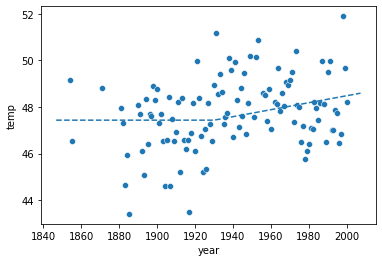

In [69]:
f, ax = plt.subplots(1, 1)

sns.scatterplot(y="temp", x="year", data=aatemp, ax=ax)

xlim = ax.get_xlim()
xr = np.linspace(xlim[0], xlim[1], num=50)
xr = np.sort(np.append(xr, c))

ax.plot(
    xr, 
    stick_mod.params[0] + 
    stick_mod.params[1]*rhs(xr, c),
    ls='--'
)

$R^2 = 0.05$ is less then for a linear fit ($<0.085$)

### next

In [162]:
n = 6
xr = np.linspace(aatemp["year"].min(), aatemp["year"].max()-1, n)
xr

array([1854., 1883., 1912., 1941., 1970., 1999.])

In [163]:
from patsy import bs
spline = bs(aatemp["year"], knots=xr, include_intercept=True)
spline

,0,1,2,3,4,5,6,7,8,9
0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.0,0.900078,0.098169,0.001746,0.000007,0.000000,0.000000,0.000000,0.000000,0.0
2,0.0,0.070852,0.564773,0.330801,0.033574,0.000000,0.000000,0.000000,0.000000,0.0
3,0.0,0.000328,0.304717,0.560447,0.134507,0.000000,0.000000,0.000000,0.000000,0.0
4,0.0,0.000041,0.276682,0.573264,0.150013,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
110,0.0,0.000000,0.000000,0.000000,0.000000,0.000185,0.019921,0.306484,0.673410,0.0
111,0.0,0.000000,0.000000,0.000000,0.000000,0.000055,0.010443,0.235364,0.754138,0.0
112,0.0,0.000000,0.000000,0.000000,0.000000,0.000007,0.003918,0.155002,0.841073,0.0
113,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000565,0.064991,0.934444,0.0


In [164]:
z = sm.OLS(aatemp["temp"], spline).fit()
z.sumary()

   coefs stderr tvalues pvalues
0  0.000  0.000     NaN     NaN
1 48.044  1.057   45.45  0.0000
2 46.547  2.492   18.68  0.0000
3 47.429  1.208   39.25  0.0000
4 46.185  0.767   60.19  0.0000
5 49.009  0.712   68.83  0.0000
6 48.699  0.874   55.69  0.0000
7 46.508  0.921   50.49  0.0000
8 49.506  0.867   57.11  0.0000
9 48.220  1.407   34.28  0.0000

n=115 p=9 Residual SD=1.407 R-squared=0.21


Fits better then the linear model; though the same problem as for the high-deg pol -- overfitting -- is present.

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


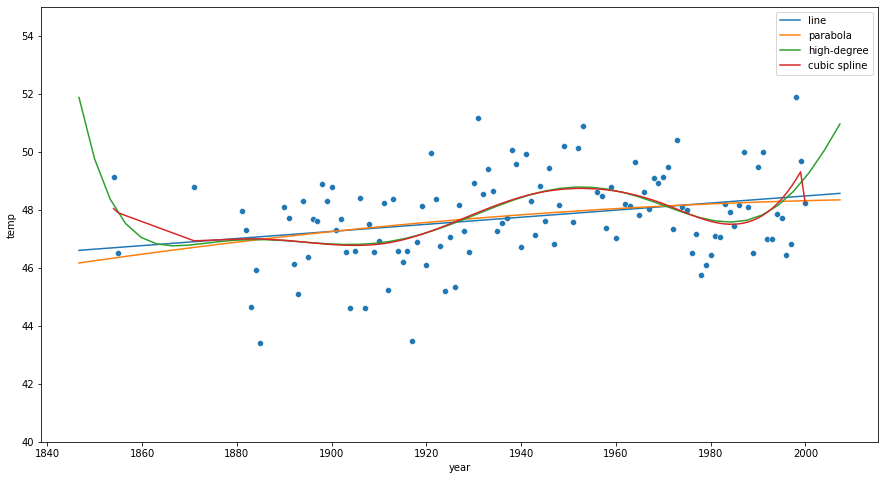

In [165]:
f, ax = plt.subplots(1, 1, figsize=(15, 8))

sns.scatterplot(y="temp", x="year", data=aatemp, ax=ax)

xlim = ax.get_xlim()
xr = np.linspace(xlim[0], xlim[1], num=50)

l = np.poly1d(np.polyfit(aatemp["year"], aatemp["temp"], 1))
p = np.poly1d(np.polyfit(aatemp["year"], aatemp["temp"], 2))
h = np.poly1d(np.polyfit(aatemp["year"], aatemp["temp"], 10))
ax.plot(xr, l(xr), label="line")
ax.plot(xr, p(xr), label="parabola")
ax.plot(xr, h(xr), label="high-degree")

ax.plot(aatemp["year"], z.fittedvalues, label="cubic spline")

ax.set_ylim([40, 55])

plt.legend()